<a href="https://colab.research.google.com/github/seven320/air_pollutants/blob/main/FP035_034.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Env

In [1]:
!nvidia-smi

Fri May 13 13:50:39 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os, sys
COLAB = "google.colab" in sys.modules

if COLAB:
    from google.colab import drive
    from google.colab import output
    drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
if COLAB:
    !pip install transformers > /dev/null
    !pip install einops > /dev/null
    !pip install optuna > /dev/null
    !pip install pyephem > /dev/null
    # !pip install timm > /dev/null
    # !pip install kaggle > /dev/null
    # !pip install kaggle_datasets > /dev/null
    # !pip install git+https://github.com/albumentations-team/albumentations
    # !pip install tensorflow-determinism
    !pip install -q iterative-stratification
    !pip install python-Levenshtein > /dev/null
    !pip install geopy > /dev/null

    # for gpu
    !git clone --recursive https://github.com/Microsoft/LightGBM
    %cd /content/LightGBM/
    !mkdir build
    !cmake -DUSE_GPU=1 
    !make -j$(nproc)
    !sudo apt-get -y install python-pip

    !sudo -H pip install setuptools pandas numpy scipy scikit-learn -U
    #pandasのエラーが出る場合は上記のコードからpandasを削除

    !sudo -H pip install setuptools numpy scipy scikit-learn -U
    %cd /content/LightGBM/python-package
    !sudo python setup.py install --precompile

    output.clear()

In [4]:
import gc
import json
import math
import os
import random
import re
import time
import copy
import warnings
from requests import get
from contextlib import contextmanager
from typing import List, Optional, TypeVar, Type, Dict
import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from pathlib import Path
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GroupKFold, train_test_split, KFold
from sklearn.preprocessing import RobustScaler, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
# from einops.layers.torch import Rearrange, Reduce
# import timm
import Levenshtein
import ephem
from geopy.distance import geodesic

from tqdm.notebook import tqdm
from transformers import AdamW, get_cosine_schedule_with_warmup
from typing import Optional, Tuple
from xgboost import XGBRegressor
import lightgbm as lgb
import optuna

In [5]:
warnings.simplefilter('ignore')

In [6]:
if COLAB:    
    NOTEBOOK_NAME = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']
    print(NOTEBOOK_NAME)

FP035-034


In [7]:
COMPE_NAME = "air_pollutants"
BASE_DIR = f"/content/drive/MyDrive/signate/{COMPE_NAME}"

# KAGGLE ONLY HAS 1, BUT OFFLINE, YOU CAN USE MORE
os.environ["CUDA_VISIBLE_DEVICES"]="0" #0,1,2,3 for four gpu

In [8]:
if COLAB:
    INPUT_DIR = Path(os.path.join(BASE_DIR ,f"input"))
    INPUT_DIR.mkdir(exist_ok=True, parents=True)

    SAVE_DIR = Path(os.path.join(BASE_DIR ,f"models/{NOTEBOOK_NAME}"))
    SAVE_DIR.mkdir(exist_ok=True, parents=True)

    OOF_DIR = Path(os.path.join(BASE_DIR, f"oof/{NOTEBOOK_NAME}"))
    OOF_DIR.mkdir(exist_ok=True, parents = True)

    SUB_DIR = Path(os.path.join(BASE_DIR, f"submission/{NOTEBOOK_NAME}"))
    SUB_DIR.mkdir(exist_ok=True, parents = True)

In [9]:
train_df = pd.read_csv(os.path.join(INPUT_DIR, "train.csv"))
test_df = pd.read_csv(os.path.join(INPUT_DIR, "test.csv"))
sample_df = pd.read_csv(os.path.join(INPUT_DIR, "submit_sample.csv"), names=["id", "predict"])

print(train_df.shape, test_df.shape, sample_df.shape)

(195941, 54) (53509, 53) (53509, 2)


## add city population

In [10]:
population_df = pd.read_csv(os.path.join(INPUT_DIR, "city_population.csv"))
population_df["City"] = population_df["Name"]

In [11]:
# 同じ都市名かつ国名のものを削除する
population_df["CC"] = population_df["Country"] + population_df["City"]
population_df["CC"].value_counts()
for k, v in population_df["CC"].value_counts().items():
    # print(k, v)
    if v > 1:
        print(f"{k} の行を削除")
        population_df = population_df[population_df["CC"] != k]

ChinaSuzhou の行を削除


In [12]:
def df_to_country_dict(df: pd.DataFrame) -> Dict:
    country_city = {}

    for t_c in set(df["Country"].tolist()):
        country_city[t_c] = []

    for country, city in zip(df["Country"], df["City"]):
        country_city[country].append(city)

    for k, v in country_city.items():
        country_city[k] = set(v)

    return country_city
    

In [13]:
train_country_city = df_to_country_dict(pd.concat([train_df, test_df]))

p_country_city = df_to_country_dict(population_df)

In [14]:
def cal_leven(str1: str, str2: str) -> float:
    # レーベンシュタイン距離の取得
    lev_dist = Levenshtein.distance(str1, str2)
    # 標準化(長い方の文字列の長さで割る)
    divider = len(str1) if len(str1) > len(str2) else len(str2)
    lev_dist = lev_dist / divider
    # 指標を合わせる(0:完全不一致 → 1:完全一致)
    return 1 - lev_dist

In [15]:
city_pairs = {}

for t_k, t_values in train_country_city.items():
    for p_k, p_values in p_country_city.items():
        # countryが一致
        if t_k != p_k:
            continue
        for t_v in t_values:
            max_score = -1
            for p_v in p_values:
                score = cal_leven(t_v, p_v)
                if max_score < score:
                    pairs = [t_v, p_v]
                    max_score = score

            if max_score > 0.8:
                city_pairs[pairs[1]] = pairs[0]
print(f"pair cities:{len(city_pairs)}")

pair cities:177


In [16]:
a = population_df["City"]
for key, value in city_pairs.items():
    # print(key, value)
    a = copy.deepcopy(a.replace(key, value))

population_df["City"] = a

In [17]:
if not "Prev" in train_df.columns:
    train_df = train_df.merge(population_df[["rank", "City", "Country", "Population", "Prev", "Growth"]], on = ["City", "Country"], how="left")
    test_df = test_df.merge(population_df[["rank", "City", "Country",  "Population", "Prev", "Growth"]], on = ["City", "Country"], how="left")

assert len(test_df) == len(sample_df)

## add target encode

In [18]:
if not "target_count" in train_df.columns:
    target_df = train_df[["Country", "pm25_mid"]].groupby("Country", as_index = 1).describe()

    target_df = target_df.rename(columns = {
        "count": "target_count",
        "mean": "target_mean",
        "std": "target_std",
        "25%": "target_25%",
        "50%": "target_50%",
        "75%": "target_75%",
        "max": "target_max"
    }).reset_index()
    train_df = train_df.merge(pd.concat([target_df["Country"], target_df["pm25_mid"]], axis = 1), on = "Country", how = "left")
    test_df = test_df.merge(pd.concat([target_df["Country"], target_df["pm25_mid"]], axis = 1), on = "Country", how = "left")

### add days

## 都市を近い順に入力(上位15)

In [19]:
use_city = 5

In [20]:
# 全ての都市を抽出
all_df = pd.concat([train_df, test_df])
lat_lons = all_df[["City", "lat", "lon"]].drop_duplicates()

In [21]:
 # 各都市ごとの距離を格納
 #
#  nearest_cities = {
#       City1 = {
            # City2: 500km
            # City3: 1000km
# }
# } 

nearest_cities = {}
for i in tqdm(range(len(lat_lons))):
    City1, lat1, lon1 = lat_lons.iloc[i]
    pos1 = np.array([lat1, lon1])
    
    nearest_city = {}
    for j in range(len(lat_lons)):
        if i == j:
            continue
        
        City2, lat2, lon2 = lat_lons.iloc[j]
        pos2 = np.array([lat2, lon2])
        
        dis = geodesic(pos1, pos2)
        
        nearest_city[City2] = dis

    nearest_cities[City1] = nearest_city

  0%|          | 0/302 [00:00<?, ?it/s]

In [22]:
target_en_bycities = train_df[["City","month", "pm25_mid"]].groupby(["City", "month"], as_index = 0).agg("mean").reset_index(drop=True)

In [23]:
nearest_sort_cities = []

for city1 in nearest_cities.keys():
    nearest_sort_city = dict(sorted(nearest_cities[city1].items(), key = lambda item: item[1])).keys()
    nearest_sort_cities.append([city1] + list(nearest_sort_city)[:use_city])

In [24]:
target_en_bycities_detail = train_df[["City","year", "month","day", "pm25_mid"]].groupby(["City", "year", "month", "day"], as_index = 0).agg("mean").reset_index(drop=True)

In [25]:
# cities = pd.DataFrame(target_en_bycities_detail["City"].unique(), columns = ["City"])
cities = pd.DataFrame(all_df["City"].unique(), columns=["City"])
year_month_day = target_en_bycities_detail.groupby(["year", "month", "day"], as_index=0).agg("mean")[["year", "month", "day"]]

city_year_month_day = pd.merge(cities, year_month_day, how = "cross")

In [26]:
target_en = pd.merge(city_year_month_day, target_en_bycities_detail, on = ["City", "year", "month", "day"], how = "left")
target_en_fillna = pd.merge(target_en, target_en_bycities, on = ["City", "month"], how = "left")
target_en_fillna["pm25_mid"] = target_en_fillna["pm25_mid_x"].combine_first(target_en_fillna["pm25_mid_y"])

In [27]:
target_en_fillna

,City,year,month,day,pm25_mid_x,pm25_mid_y,pm25_mid
0,Brisbane,2019,1,1,19.901,33.808158,19.901
1,Brisbane,2019,1,2,61.697,33.808158,61.697
2,Brisbane,2019,1,3,20.617,33.808158,20.617
3,Brisbane,2019,1,4,28.982,33.808158,28.982
4,Brisbane,2019,1,5,23.326,33.808158,23.326
...,...,...,...,...,...,...,...
330685,Johannesburg,2021,12,27,NaN,NaN,NaN
330686,Johannesburg,2021,12,28,NaN,NaN,NaN
330687,Johannesburg,2021,12,29,NaN,NaN,NaN
330688,Johannesburg,2021,12,30,NaN,NaN,NaN


In [28]:
# 1日前と後を追加
target_en_fillna["1dbefore_pm25_mid"] = target_en_fillna.groupby("City").shift()["pm25_mid"]
target_en_fillna["1dafter_pm25_mid"] = target_en_fillna.groupby("City").shift(-1)["pm25_mid"]

In [29]:
# Config
NUM_FOLDS = 5

In [30]:
#############
## Utility ##
#############
@contextmanager
def timer(name: str):
    t0 = time.time()
    print(f"[{name}] start")
    yield
    print(f"[{name}] done - elapsed {time.time() - t0:.2f}s")

In [31]:
def seed_everything(seed):
    """
    Seeds basic parameters for reproductibility of results
    
    Arguments:
        seed {int} -- Number of the seed
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def set_seed(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

In [32]:
train_df.head()

,id,year,month,day,Country,City,lat,lon,co_cnt,co_min,...,Prev,Growth,target_count,target_mean,target_std,min,target_25%,target_50%,target_75%,target_max
0,1,2019,1,1,Australia,Brisbane,-27.46794,153.02809,38,0.749,...,2439467.0,0.0134,5656.0,37.362265,25.919644,0.0,19.526,28.6445,52.50325,189.517
1,2,2019,1,1,Australia,Darwin,-12.46113,130.84185,47,2.594,...,NaN,NaN,5656.0,37.362265,25.919644,0.0,19.526,28.6445,52.50325,189.517
2,3,2019,1,1,Australia,Melbourne,-37.81400,144.96332,17,1.190,...,5061439.0,0.0176,5656.0,37.362265,25.919644,0.0,19.526,28.6445,52.50325,189.517
3,4,2019,1,1,Australia,Newcastle,-32.92953,151.78010,63,4.586,...,NaN,NaN,5656.0,37.362265,25.919644,0.0,19.526,28.6445,52.50325,189.517
4,5,2019,1,1,Australia,Perth,-31.95224,115.86140,47,4.689,...,2067333.0,0.0122,5656.0,37.362265,25.919644,0.0,19.526,28.6445,52.50325,189.517


In [33]:
train_city = train_df["City"].unique().tolist()
test_city = test_df["City"].unique().tolist()

train_city_cnt = len(train_city)
test_city_cnt = len(test_city)

print(f"train city count: {train_city_cnt}")
print(f"test city count: {test_city_cnt}")

print(f"{len(set(train_city) & set(test_city))}")

train city count: 239
test city count: 63
0


In [34]:
kf = GroupKFold(n_splits = NUM_FOLDS)

if not "kfold" in train_df.columns:
    folds = copy.deepcopy(train_df[["id"]])
    folds["kfold"] = -1

    for fold, (train_idx, valid_idx) in enumerate(kf.split(train_df, train_df["pm25_mid"], train_df["City"])):
        print(f"train_idx: {len(train_idx)}, valid_idx: {len(valid_idx)}")
        folds.loc[valid_idx, "kfold"] = fold

    train_df = train_df.merge(folds[["id", "kfold"]], on="id", how="left")

train_idx: 156755, valid_idx: 39186
train_idx: 156758, valid_idx: 39183
train_idx: 156760, valid_idx: 39181
train_idx: 156730, valid_idx: 39211
train_idx: 156761, valid_idx: 39180


# Train

In [35]:
import logging
from typing import List, Optional, TypeVar

import pandas as pd

class AbstractFeatureTransformer:
    def __init__(self):
        self.name = self.__class__.__name__

    def fit_transform(self, input_df: pd.DataFrame, y=None):
        self.fit(input_df, y)
        return self.transform(input_df)

    def fit(self, input_df: pd.DataFrame, y=None):
        pass

    def transform(self, input_df: pd.DataFrame) -> pd.DataFrame:
        raise NotImplementedError

Transformer = TypeVar("Transformer", bound=AbstractFeatureTransformer)

def extract_features(input_df: pd.DataFrame,
                     transformers: List[Transformer],
                     fit: bool = True,
                     logger: Optional[logging.Logger] = None):
    feature_dfs = []
    for transformer in transformers:
        # timerはブロックの実行時間を計測するユーティリティ
        with timer(f"Extract features with {transformer.name}", logger):
            if fit:
                feature_dfs.append(transformer.fit_transform(input_df))
            else:
                feature_dfs.append(transformer.transform(input_df))
    all_features = pd.concat(feature_dfs, axis=1)
    return all_features

In [36]:
class Numericals(AbstractFeatureTransformer):
    def transform(self, input_df: pd.DataFrame) -> pd.DataFrame:
        cols = [pd.api.types.is_numeric_dtype(dtype) for dtype in input_df.dtypes]
        return input_df.loc[:, cols]

class LabelEncoding(AbstractFeatureTransformer):
    def __init__(self, columns: List[str]):
        super().__init__()
        self.le_columns = columns
        self.encoders = {
            column: LabelEncoder()
            for column in self.le_columns
        }
        self.__is_fitted = False

    def fit(self, input_df: pd.DataFrame, y: Optional[np.ndarray] = None):
        """
        ラベルに変換する前に欠損値を埋める
        """
        for column in self.le_columns:
            self.encoders[column].fit(input_df[column].fillna(""))
        self.__is_fitted = True

    def transform(
        self, 
        input_df: pd.DataFrame, 
        y: Optional[np.ndarray] = None
    ) -> pd.DataFrame:
        assert self.__is_fitted, "You need to call `fit` first."
        encoded = {}
        for column in self.le_columns:
            encoded[column] = self.encoders[column].transform(
                input_df[column].fillna(""))
        return pd.DataFrame(encoded)

In [37]:
def preprocess_all(train_df:pd.DataFrame, test_df:pd.DataFrame)->pd.DataFrame:
    all_df = pd.concat([train_df, test_df])

    mids = ["co_mid", "o3_mid", "so2_mid", "no2_mid", "temperature_mid", "humidity_mid", "pressure_mid", "ws_mid", "dew_mid", 
            "co_max", "o3_max", "so2_max", "no2_max", "temperature_max", "humidity_max", "pressure_max", "ws_max", "dew_max"]
    cnt = 1
    for i in range(len(mids)):
        if f"scaled_{mids[i]}" in train_df.columns:
            break
        scaler = MinMaxScaler()
        scaler.fit(all_df[[mids[i]]])
        train_df[f"scaled_{mids[i]}"] = scaler.transform(train_df[[mids[i]]])
        test_df[f"scaled_{mids[i]}"] = scaler.transform(test_df[[mids[i]]])
        cnt += 1
    print("min max scaler")

    return train_df, test_df

In [38]:
def preprocess(df:pd.DataFrame)->pd.DataFrame:
    df_ = copy.deepcopy(df)
    # 年月/年月日を追加

    df_["year_month"] = df_["year"].astype("str") + df_["month"].astype("str")
    df_["year_month_day"] = df_["year"].astype("str") + df_["month"].astype("str") + df_["day"].astype("str")
    df_["month_day"] = df_["month"].astype("str") + df_["day"].astype("str")

    # 月日国/月日都市を追加
    df_["month_day_country"] = df_["month"].astype("str") + df_["day"].astype("str") + df_["Country"].astype("str") 
    df_["month_day_city"] =  df_["month"].astype("str") + df_["day"].astype("str") + df_["City"].astype("str") 

    # 経度をcosに変換
    cnt = 0

    if not "lon_cos" in df_.columns:
        df_["lon_cos"] = np.cos(np.radians((df_["lon"] + 180)))
        df_["lon_sin"] = np.sin(np.radians((df_["lon"] + 180)))
        df_["month_cos"] = np.cos(np.radians(df_["month"] / 12 * 360))
        df_["month_sin"] = np.sin(np.radians(df_["month"] / 12 * 360))
        print("add lon_cos, lon_sin, month_cos, month_sin")
        cnt += 4

    # 四則演算

    # 南半球を北半球のmonthに変更
    if not "month_world" in df_.columns:
        df_["month_world"] = df_["month"]
        df_.loc[df_["lat"] < 0, "month_world"] = df_["month"] + 6
        df_.loc[df_["month_world"] > 12, "month_world"] = df_["month"] - 6
        print("add month_world")
        cnt += 1
    # mid同士を4則
    columns = df_.columns
    mids = []
    for c in columns:
        if "_mid" in c and c != "pm25_mid":
            mids.append(c)

    # 曜日を追加
    def _cal_sun_time(lat:float, lon:float, year:float, month:float, day: float)->float:
        location = ephem.Observer()
        location.lat = str(lat)
        location.lon = str(lon)
        sun = ephem.Sun()

        location.date = datetime.date(year = int(year), month = int(month), day = int(day))
        sun_time_tmp1 = ephem.localtime(location.next_rising(sun)) - ephem.localtime(location.next_setting(sun))
        sun_time_tmp2 = ephem.localtime(location.next_setting(sun)) - ephem.localtime(location.next_rising(sun))

        sun_time = max(sun_time_tmp1.seconds, sun_time_tmp2.seconds)

        return sun_time
    if not "sun_time" in df_.columns:
        u_cols = ["lat", "lon", "year", "month", "day"]

        df_["sun_time"] = -1
        df_["week"] = -1

        mini_df = df_[u_cols]

        sun_time = np.zeros(len(df_))
        weeks = np.zeros(len(df_))
        for i in tqdm(range(len(mini_df))):
            lat, lon, year, month, day = mini_df.iloc[i]
            sun_time[i] = _cal_sun_time(lat, lon, year, month, day)

            # 曜日
            date = datetime.date(int(year), int(month), int(day))
            weeks[i] = date.weekday()

        df_["sun_time"] = sun_time
        df_["week"] = weeks

        print("add sun_time, weeks")
    cnt += 2

    mids = ["co_mid", "o3_mid", "so2_mid", "no2_mid", "temperature_mid", "humidity_mid", "pressure_mid", "ws_mid", "dew_mid"]
    for i in range(len(mids)):
        for j in range(i):
            mid0, mid1 = mids[i], mids[j]
            df_[f"{mid0}+{mid1}"] = df_[mid0] + df_[mid1]

            cnt += 1
    print("add mids + cal")
    scaled_mids = ["scaled_co_mid", "scaled_o3_mid", "scaled_so2_mid", "scaled_no2_mid"]
    for i in range(len(scaled_mids)):
        for j in range(i):
            mid0, mid1 = scaled_mids[i], scaled_mids[j]
            df_[f"{mid0}+{mid1}"] = df_[mid0] + df_[mid1]
            cnt += 1
            for k in range(j):
                mid2 = scaled_mids[k]
                df_[f"{mid0}+{mid1}+{mid2}"] = df_[mid0] + df_[mid1] + df_[mid2]
                cnt += 1
                for l in range(k):
                    mid3 = scaled_mids[l]
                    df_[f"{mid0}+{mid1}+{mid2}+{mid3}"] = df_[mid0] + df_[mid1] + df_[mid2] + df_[mid3]
                    cnt += 1
    print("add scaled mids")

    maxs = ["co_max", "o3_max", "so2_max", "no2_max", "temperature_max", "humidity_max", "pressure_max", "ws_max", "dew_max"]
    for i in range(len(maxs)):
        for j in range(i):
            max0, max1 = maxs[i], maxs[j]
            df_[f"{max0}+{max1}"] = df_[max0] + df_[max1]

    scaled_maxs = ["scaled_co_max", "scaled_o3_max", "scaled_so2_max", "scaled_no2_max"]
    for i in range(len(scaled_maxs)):
        for j in range(i):
            max0, max1 = scaled_maxs[i], scaled_maxs[j]
            df_[f"{max0}+{max1}"] = df_[max0] + df_[max1]
            cnt += 1
            for k in range(j):
                max2 = scaled_maxs[k]
                df_[f"{max0}+{max1}+{max2}"] = df_[max0] + df_[max1] + df_[max2]
                cnt += 1
                for l in range(k):
                    max3 = scaled_maxs[l]
                    df_[f"{max0}+{max1}+{max2}+{max3}"] = df_[max0] + df_[max1] + df_[max2] + df_[max3]
                    cnt += 1
    print("add scaled maxs")

    print(f"add {cnt} columns")

    return df_

In [39]:
class AbstractTreeModel:
    def __init__(self, prediction_type="regression"):
        self.model = None
        self.prediction_type = prediction_type

    def train(self,
              params: dict,
              X_train: pd.DataFrame,
              y_train: np.ndarray,
              X_val: pd.DataFrame,
              y_val: np.ndarray,
              train_weights: Optional[np.ndarray] = None,
              val_weights: Optional[np.ndarray] = None,
              train_params: Optional[dict] = None):
        if train_params is None:
            train_params = {}

        model = self._train(
            params,
            X_train, y_train,
            X_val, y_val,
            train_weights, val_weights,
            train_params)
        self.model = model
        return self

    def _train(self,
               params,
               X_train,
               y_train,
               X_val,
               y_val,
               train_weights,
               val_weights,
               train_params):
        raise NotImplementedError

    def predict(self, X: pd.DataFrame) -> np.ndarray:
        raise NotImplementedError

    @property
    def feature_names_(self):
        raise NotImplementedError

    @property
    def feature_importances_(self):
        raise NotImplementedError

    def _check_if_trained(self):
        assert self.model is not None, "You need to train the model first"

class LGBModel(AbstractTreeModel):
    def _train(self,
               params,
               X_train, y_train,
               X_val, y_val,
               train_weights, val_weights,
               train_params):
        trn_data = lgb.Dataset(X_train, y_train, weight=train_weights)
        val_data = lgb.Dataset(X_val, y_val, weight=val_weights)
        model = lgb.train(params=params,
                          train_set=trn_data,
                          valid_sets=[trn_data, val_data],
                          **train_params,)
                        #   verbose_eval=False)
        return model

    def predict(self, X: pd.DataFrame) -> np.ndarray:
        self._check_if_trained()
        return self.model.predict(X, num_iteration=self.model.best_iteration)

    @property
    def feature_names_(self):
        self._check_if_trained()
        return self.model.feature_name()

    @property
    def feature_importances_(self):
        self._check_if_trained()
        return self.model.feature_importance(importance_type="gain")

def get_tree_model(name: str) -> Type[AbstractTreeModel]:
    DEFINED_MODELS = {
        "lgb": LGBModel,
        # 実装していない
        # "xgb": XGBModel,
        # "cat": CatBoostModel
    }
    model = DEFINED_MODELS.get(name)
    if model is None:
        raise ValueError(
            """Invalid model name: {}.
            Pre-defined model names are as follows: {}""".format(
                name,
                ",".join(DEFINED_MODELS.keys())
            ))
    return model

In [40]:
def viz_feature_importances(feature_importances: pd.DataFrame)-> None:
    fi_gby = feature_importances.groupby("feature").agg({
        "importance": ["mean", "std"]
    }).sort_values(("importance", "mean"), ascending=0).index
    plt.figure(figsize=(30, 20))

    sns.barplot(x="importance", y="feature", data=feature_importances, order=fi_gby)

    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.show()
    # plt.savefig('lgbm_importances-01.png')

In [41]:
train_params = {
    "num_boost_round": 20000,
    "callbacks": [
                  lgb.early_stopping(stopping_rounds= 500, verbose=True),
                  lgb.log_evaluation(period = 3000)
    ]
}

In [42]:
num_cols = [c for c in train_df.columns if train_df[c].dtype != np.object]
if "id" in num_cols:
    num_cols.remove("id")
if "kfold" in num_cols:
    num_cols.remove("kfold")
num_cols.remove("pm25_mid")

target_cols = "pm25_mid"

In [43]:
train_df0, test_df0 = preprocess_all(train_df, test_df)

train_df1 = preprocess(train_df0)
test_df1 = preprocess(test_df0)

min max scaler
add lon_cos, lon_sin, month_cos, month_sin
add month_world


  0%|          | 0/195941 [00:00<?, ?it/s]

add sun_time, weeks
add mids + cal
add scaled mids
add scaled maxs
add 65 columns
add lon_cos, lon_sin, month_cos, month_sin
add month_world


  0%|          | 0/53509 [00:00<?, ?it/s]

add sun_time, weeks
add mids + cal
add scaled mids
add scaled maxs
add 65 columns


In [44]:
all_df1 = pd.concat([train_df1, test_df1])

after_before_cs = ["year", "month", "day", "co_mid", "o3_mid", "so2_mid", "no2_mid", "temperature_mid", "humidity_mid", "pressure_mid", "ws_mid", "dew_mid",
            "scaled_no2_mid+scaled_so2_mid+scaled_co_mid"]

today_df = pd.merge(city_year_month_day, 
            all_df1[after_before_cs + ["City"]],
            on=["City", "year", "month", "day"], how = "left")

daybefore_df= today_df.groupby(["City"]).shift()
dayafter_df = today_df.groupby(["City"]).shift(-1)

columns_dic = {}
daybefore_cs = []
for c in after_before_cs:
    columns_dic[c] = f"1dbefore_{c}"
    daybefore_cs.append(f"1dbefore_{c}")

daybefore_df = daybefore_df.rename(columns = columns_dic)

columns_dic = {}
dayafter_cs = []
for c in after_before_cs:
    columns_dic[c] = f"1dafter_{c}"
    dayafter_cs.append(f"1dafter_{c}")

dayafter_df = dayafter_df.rename(columns = columns_dic)

beforeafterday_df = pd.concat([today_df[["City", "year", "month", "day"]], daybefore_df[daybefore_cs], dayafter_df[dayafter_cs]], axis =1)

In [45]:
train_df_ = pd.merge(train_df1, beforeafterday_df , on = ["City", "year", "month", "day"], how = "left")
test_df_ = pd.merge(test_df1, beforeafterday_df, on = ["City", "year", "month", "day"], how = "left")

In [46]:
cat_cols = ["Country", "City", "year_month", "year_month_day", "month_day", "month_day_city", "month_day_country", "nearest_city"] 

num_cols = list(set(train_df_.columns) - set(cat_cols + ["pm25_mid", "kfold", "id", "year"])) + \
 ["nearest_pm25_mid", "nearest_1dbefore_pm25_mid", "nearest_1dafter_pm25_mid"] + \
[f"dis{i}km_pm25_mid" for i in [50, 100, 300, 500, 1000]]
use_cols = num_cols + cat_cols

In [47]:
models = []

oof_df = train_df_[["id"]]
oof_df["oof"] = -1

from lightgbm import early_stopping
from lightgbm import log_evaluation

# for i in range(NUM_FOLDS):
i = 0
train_data = train_df_[train_df_["kfold"] != i].reset_index(drop = True)
valid_data = train_df_[train_df_["kfold"] == i].reset_index(drop = True)
print("-" * 5 + f"FOLD {i + 1}/{NUM_FOLDS}" + "-"*5)
print(f"train_data nums: {len(train_data)}, valid_data nums: {len(valid_data)}")

# fold内での最近傍を探す
train_data = train_df_[train_df_["kfold"] != i].reset_index(drop = True)
print(len(train_data["City"].unique()))

# 同じfoldの中で最近傍な都市があった場合はその年のtarget_encodingを実施
# nearest_city_fold_df = copy.deepcopy(nearest_city_df)
fold_cities = train_data["City"].unique()

fold_nearest_cities = []
for (base_c, city1, city2, city3, city4, city5) in nearest_sort_cities:
    if city1 in fold_cities:
        nearest_city = city1
    elif city2 in fold_cities:
        nearest_city = city2
    elif city3 in fold_cities:
        nearest_city = city3
    elif city4 in fold_cities:
        nearest_city = city4
    elif city5 in fold_cities:
        nearest_city = city5
    fold_nearest_cities.append([base_c, nearest_city])
fold_nearest_cities_df = pd.DataFrame(fold_nearest_cities, columns = ["City", "nearest_city"])

# add city distance
fold_nearest_cities_df["distance_km"] = -1
for j in range(fold_nearest_cities_df.shape[0]):
    city, nearest_city = fold_nearest_cities_df.loc[j, ["City", "nearest_city"]]
    dis = nearest_cities[city][nearest_city]
    fold_nearest_cities_df.loc[j, "distance_km"] = dis.km

target_en_fillna_ = target_en_fillna.rename(columns = {"City": "nearest_city", "pm25_mid": "nearest_pm25_mid", 
                                                        "1dafter_pm25_mid":"nearest_1dafter_pm25_mid", "1dbefore_pm25_mid":"nearest_1dbefore_pm25_mid"})
fold_nearest_city_target_en = fold_nearest_cities_df.merge(target_en_fillna_, how = "left", on= "nearest_city")

train_data = train_data.merge(fold_nearest_city_target_en, how = "left", on = ["City", "year", "month", "day"])
valid_data = valid_data.merge(fold_nearest_city_target_en, how = "left", on = ["City", "year", "month", "day"])

# 距離に応じた近傍の都市のpm25_mid
for dis in [50, 100, 300, 500, 1000]:
    train_data[f"dis{dis}km_pm25_mid"] = np.nan
    valid_data[f"dis{dis}km_pm25_mid"] = np.nan

    train_data.loc[train_data["distance_km"] <= dis, f"dis{dis}km_pm25_mid"] = train_data.loc[train_data["distance_km"] <= dis, "nearest_pm25_mid"]
    valid_data.loc[valid_data["distance_km"] <= dis, f"dis{dis}km_pm25_mid"] = valid_data.loc[valid_data["distance_km"] <= dis, "nearest_pm25_mid"]

# test
if i == 0:
    test_nearest_cities = []
    for (base_c, city1, city2, city3, city4, city5) in nearest_sort_cities:
        nearest_city = city1
        test_nearest_cities.append([base_c, nearest_city])
    test_nearest_cities_df = pd.DataFrame(test_nearest_cities, columns = ["City", "nearest_city"])
    
    for j in range(test_nearest_cities_df.shape[0]):
        city, nearest_city = test_nearest_cities_df.loc[j, ["City", "nearest_city"]]
        dis = nearest_cities[city][nearest_city]
        test_nearest_cities_df.loc[j, "distance_km"] = dis.km

    test_nearest_city_target_en = test_nearest_cities_df.merge(target_en_fillna_, how="left", on = "nearest_city")
    test_df_ = test_df_.merge(test_nearest_city_target_en, how="left", on=["City", "year", "month", "day"])
    for dis in [50, 100, 300, 500, 1000]:
        test_df_[f"dis{dis}km_pm25_mid"] = np.nan
        test_df_.loc[test_df_["distance_km"] <= dis, f"dis{dis}km_pm25_mid"] = test_df_.loc[test_df_["distance_km"] <= dis, "nearest_pm25_mid"]
    test_df__ = copy.deepcopy(test_df_)

for c in cat_cols:
    le = LabelEncoder()
    le.fit(pd.concat([train_data, valid_data, test_df_])[c])
    train_data[c] = le.transform(train_data[c])
    valid_data[c] = le.transform(valid_data[c])
    if i == 0:
        test_df__[c] = le.transform(test_df_[c])

-----FOLD 1/5-----
train_data nums: 156755, valid_data nums: 39186
192


In [48]:
lgb_train = lgb.Dataset(train_data[use_cols], train_data[target_cols])
lgb_eval = lgb.Dataset(valid_data[use_cols], valid_data[target_cols])

In [54]:
lgb_train = lgb.Dataset(train_data[use_cols], train_data[target_cols])
lgb_eval = lgb.Dataset(valid_data[use_cols], valid_data[target_cols])

def objective(trial):
    params= {
            'boosting': trial.suggest_categorical("boosting", ["gbdt", "rf"]),
            'objective': 'rmse',
            'metric': 'rmse',
            'learning_rate': trial.suggest_uniform('learning_rate', 0.001, 0.1),
            "max_depth": trial.suggest_categorical("max_depth", [8, 16, 32]),
            "num_leaves": trial.suggest_categorical("num_leaves", [8, 16, 32, 64]),
            'subsample': 0.7,
            'subsample_freq': 1,
            "min_data_in_leaf": 30,
            "device": "gpu",  
            "seed":2022,
    }
    model = get_tree_model("lgb")()
    gbm = lgb.train(params, lgb_train, valid_sets=lgb_eval, **train_params)
    preds = gbm.predict(valid_data[use_cols])

    accuracy = np.sqrt(mean_squared_error(valid_data[target_cols], preds))
    return accuracy

In [55]:
study = optuna.create_study(direction = "minimize")
study.optimize(objective, n_trials = 50)

[I 2022-05-13 14:09:02,429] A new study created in memory with name: no-name-1b662eb1-efc8-441b-a6ed-02d7b9ad5902


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 50438
[LightGBM] [Info] Number of data points in the train set: 156755, number of used features: 222
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 221 dense feature groups (33.49 MB) transferred to GPU in 0.022153 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 58.695189
Training until validation scores don't improve for 500 rounds
Early stopping, best iteration is:
[505]	valid_0's rmse: 24.3583


[I 2022-05-13 14:09:22,307] Trial 0 finished with value: 24.358315253497143 and parameters: {'boosting': 'gbdt', 'learning_rate': 0.0865706827969821, 'max_depth': 16, 'num_leaves': 16}. Best is trial 0 with value: 24.358315253497143.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 50438
[LightGBM] [Info] Number of data points in the train set: 156755, number of used features: 222
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 221 dense feature groups (33.49 MB) transferred to GPU in 0.021343 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 58.695189
Training until validation scores don't improve for 500 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[880]	valid_0's rmse: 24.2448


[I 2022-05-13 14:10:06,943] Trial 1 finished with value: 24.24481984414156 and parameters: {'boosting': 'gbdt', 'learning_rate': 0.0797959149576395, 'max_depth': 8, 'num_leaves': 64}. Best is trial 1 with value: 24.24481984414156.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 50438
[LightGBM] [Info] Number of data points in the train set: 156755, number of used features: 222
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 221 dense feature groups (33.49 MB) transferred to GPU in 0.022390 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 58.695189
Training until validation scores don't improve for 500 rounds
Early stopping, best iteration is:
[771]	valid_0's rmse: 24.1514


[I 2022-05-13 14:10:52,485] Trial 2 finished with value: 24.15135080407883 and parameters: {'boosting': 'gbdt', 'learning_rate': 0.0783457383655693, 'max_depth': 16, 'num_leaves': 64}. Best is trial 2 with value: 24.15135080407883.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 50438
[LightGBM] [Info] Number of data points in the train set: 156755, number of used features: 222
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 221 dense feature groups (33.49 MB) transferred to GPU in 0.021456 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 58.695189
Training until validation scores don't improve for 500 rounds


[I 2022-05-13 14:10:58,531] Trial 3 finished with value: 30.54106057523532 and parameters: {'boosting': 'rf', 'learning_rate': 0.07731088839494596, 'max_depth': 16, 'num_leaves': 8}. Best is trial 2 with value: 24.15135080407883.


Early stopping, best iteration is:
[8]	valid_0's rmse: 30.5411
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 50438
[LightGBM] [Info] Number of data points in the train set: 156755, number of used features: 222
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 221 dense feature groups (33.49 MB) transferred to GPU in 0.022998 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 58.695189
Training until validation scores don't improve for 500 rounds
Early stopping, best iteration is:
[66]	valid_0's rmse: 28.2017


[I 2022-05-13 14:11:16,094] Trial 4 finished with value: 28.201722108682137 and parameters: {'boosting': 'rf', 'learning_rate': 0.08167945752793236, 'max_depth': 32, 'num_leaves': 32}. Best is trial 2 with value: 24.15135080407883.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 50438
[LightGBM] [Info] Number of data points in the train set: 156755, number of used features: 222
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 221 dense feature groups (33.49 MB) transferred to GPU in 0.021246 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 58.695189
Training until validation scores don't improve for 500 rounds
[3000]	valid_0's rmse: 24.2248
Early stopping, best iteration is:
[3619]	valid_0's rmse: 24.1954


[I 2022-05-13 14:11:55,192] Trial 5 finished with value: 24.195398263658646 and parameters: {'boosting': 'gbdt', 'learning_rate': 0.04160352650432623, 'max_depth': 32, 'num_leaves': 8}. Best is trial 2 with value: 24.15135080407883.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 50438
[LightGBM] [Info] Number of data points in the train set: 156755, number of used features: 222
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 221 dense feature groups (33.49 MB) transferred to GPU in 0.021787 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 58.695189
Training until validation scores don't improve for 500 rounds
Early stopping, best iteration is:
[66]	valid_0's rmse: 28.2024


[I 2022-05-13 14:12:12,834] Trial 6 finished with value: 28.202432818016938 and parameters: {'boosting': 'rf', 'learning_rate': 0.025646465015746057, 'max_depth': 32, 'num_leaves': 32}. Best is trial 2 with value: 24.15135080407883.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 50438
[LightGBM] [Info] Number of data points in the train set: 156755, number of used features: 222
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 221 dense feature groups (33.49 MB) transferred to GPU in 0.021313 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 58.695189
Training until validation scores don't improve for 500 rounds


[I 2022-05-13 14:12:22,417] Trial 7 finished with value: 29.515521125686742 and parameters: {'boosting': 'rf', 'learning_rate': 0.07319985856666707, 'max_depth': 8, 'num_leaves': 16}. Best is trial 2 with value: 24.15135080407883.


Early stopping, best iteration is:
[6]	valid_0's rmse: 29.5155
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 50438
[LightGBM] [Info] Number of data points in the train set: 156755, number of used features: 222
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 221 dense feature groups (33.49 MB) transferred to GPU in 0.021393 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 58.695189
Training until validation scores don't improve for 500 rounds
Early stopping, best iteration is:
[2353]	valid_0's rmse: 24.0957


[I 2022-05-13 14:12:50,169] Trial 8 finished with value: 24.09566364888335 and parameters: {'boosting': 'gbdt', 'learning_rate': 0.04885142879043351, 'max_depth': 16, 'num_leaves': 8}. Best is trial 8 with value: 24.09566364888335.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 50438
[LightGBM] [Info] Number of data points in the train set: 156755, number of used features: 222
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 221 dense feature groups (33.49 MB) transferred to GPU in 0.022115 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 58.695189
Training until validation scores don't improve for 500 rounds
Early stopping, best iteration is:
[66]	valid_0's rmse: 28.2017


[I 2022-05-13 14:13:08,213] Trial 9 finished with value: 28.201722123285645 and parameters: {'boosting': 'rf', 'learning_rate': 0.0748806650477351, 'max_depth': 32, 'num_leaves': 32}. Best is trial 8 with value: 24.09566364888335.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 50438
[LightGBM] [Info] Number of data points in the train set: 156755, number of used features: 222
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 221 dense feature groups (33.49 MB) transferred to GPU in 0.021362 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 58.695189
Training until validation scores don't improve for 500 rounds
[3000]	valid_0's rmse: 25.2246
[6000]	valid_0's rmse: 24.7487
[9000]	valid_0's rmse: 24.5798
[12000]	valid_0's rmse: 24.4798
[15000]	valid_0's rmse: 24.4067
[18000]	valid_0's rmse: 24.3546
Did not meet early stopping. Best iteration is:
[19957]	valid_0's rmse: 24.3231


[I 2022-05-13 14:16:27,439] Trial 10 finished with value: 24.32309547378717 and parameters: {'boosting': 'gbdt', 'learning_rate': 0.004374262520348907, 'max_depth': 16, 'num_leaves': 8}. Best is trial 8 with value: 24.09566364888335.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 50438
[LightGBM] [Info] Number of data points in the train set: 156755, number of used features: 222
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 221 dense feature groups (33.49 MB) transferred to GPU in 0.023282 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 58.695189
Training until validation scores don't improve for 500 rounds
Early stopping, best iteration is:
[600]	valid_0's rmse: 24.1161


[I 2022-05-13 14:17:08,323] Trial 11 finished with value: 24.116063678123485 and parameters: {'boosting': 'gbdt', 'learning_rate': 0.05301380090723735, 'max_depth': 16, 'num_leaves': 64}. Best is trial 8 with value: 24.09566364888335.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 50438
[LightGBM] [Info] Number of data points in the train set: 156755, number of used features: 222
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 221 dense feature groups (33.49 MB) transferred to GPU in 0.026877 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 58.695189
Training until validation scores don't improve for 500 rounds
Early stopping, best iteration is:
[609]	valid_0's rmse: 24.233


[I 2022-05-13 14:17:49,848] Trial 12 finished with value: 24.233025782410312 and parameters: {'boosting': 'gbdt', 'learning_rate': 0.051892962183919734, 'max_depth': 16, 'num_leaves': 64}. Best is trial 8 with value: 24.09566364888335.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 50438
[LightGBM] [Info] Number of data points in the train set: 156755, number of used features: 222
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 221 dense feature groups (33.49 MB) transferred to GPU in 0.021977 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 58.695189
Training until validation scores don't improve for 500 rounds
Early stopping, best iteration is:
[2048]	valid_0's rmse: 23.9658


[I 2022-05-13 14:19:21,297] Trial 13 finished with value: 23.965768503152223 and parameters: {'boosting': 'gbdt', 'learning_rate': 0.05184057694385375, 'max_depth': 16, 'num_leaves': 64}. Best is trial 13 with value: 23.965768503152223.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 50438
[LightGBM] [Info] Number of data points in the train set: 156755, number of used features: 222
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 221 dense feature groups (33.49 MB) transferred to GPU in 0.021620 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 58.695189
Training until validation scores don't improve for 500 rounds
[3000]	valid_0's rmse: 24.1907
Early stopping, best iteration is:
[3670]	valid_0's rmse: 24.1246


[I 2022-05-13 14:20:01,245] Trial 14 finished with value: 24.124642729192832 and parameters: {'boosting': 'gbdt', 'learning_rate': 0.03815100914424451, 'max_depth': 16, 'num_leaves': 8}. Best is trial 13 with value: 23.965768503152223.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 50438
[LightGBM] [Info] Number of data points in the train set: 156755, number of used features: 222
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 221 dense feature groups (33.49 MB) transferred to GPU in 0.021868 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 58.695189
Training until validation scores don't improve for 500 rounds
Early stopping, best iteration is:
[1483]	valid_0's rmse: 24.1602


[I 2022-05-13 14:21:13,111] Trial 15 finished with value: 24.160150039389155 and parameters: {'boosting': 'gbdt', 'learning_rate': 0.060451860356106016, 'max_depth': 16, 'num_leaves': 64}. Best is trial 13 with value: 23.965768503152223.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 50438
[LightGBM] [Info] Number of data points in the train set: 156755, number of used features: 222
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 221 dense feature groups (33.49 MB) transferred to GPU in 0.021479 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 58.695189
Training until validation scores don't improve for 500 rounds
[3000]	valid_0's rmse: 24.2428
[6000]	valid_0's rmse: 24.0268
Early stopping, best iteration is:
[5654]	valid_0's rmse: 24.0087


[I 2022-05-13 14:22:12,512] Trial 16 finished with value: 24.00874963550214 and parameters: {'boosting': 'gbdt', 'learning_rate': 0.02486138813413929, 'max_depth': 8, 'num_leaves': 8}. Best is trial 13 with value: 23.965768503152223.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 50438
[LightGBM] [Info] Number of data points in the train set: 156755, number of used features: 222
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 221 dense feature groups (33.49 MB) transferred to GPU in 0.024227 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 58.695189
Training until validation scores don't improve for 500 rounds
[3000]	valid_0's rmse: 24.1221
Early stopping, best iteration is:
[3598]	valid_0's rmse: 24.0483


[I 2022-05-13 14:23:09,510] Trial 17 finished with value: 24.048253313670372 and parameters: {'boosting': 'gbdt', 'learning_rate': 0.023413415734791613, 'max_depth': 8, 'num_leaves': 16}. Best is trial 13 with value: 23.965768503152223.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 50438
[LightGBM] [Info] Number of data points in the train set: 156755, number of used features: 222
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 221 dense feature groups (33.49 MB) transferred to GPU in 0.023340 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 58.695189
Training until validation scores don't improve for 500 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3000]	valid_0's rmse: 24.0606
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

[I 2022-05-13 14:29:43,253] Trial 18 finished with value: 23.82480415132184 and parameters: {'boosting': 'gbdt', 'learning_rate': 0.006626844677435149, 'max_depth': 8, 'num_leaves': 64}. Best is trial 18 with value: 23.82480415132184.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 50438
[LightGBM] [Info] Number of data points in the train set: 156755, number of used features: 222
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 221 dense feature groups (33.49 MB) transferred to GPU in 0.022490 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 58.695189
Training until validation scores don't improve for 500 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2022-05-13 14:30:13,932] Trial 19 finished with value: 24.590163732797592 and parameters: {'boosting': 'gbdt', 'learning_rate': 0.09918385821081029, 'max_depth': 8, 'num_leaves': 64}. Best is trial 18 with value: 23.82480415132184.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 50438
[LightGBM] [Info] Number of data points in the train set: 156755, number of used features: 222
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 221 dense feature groups (33.49 MB) transferred to GPU in 0.021259 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 58.695189
Training until validation scores don't improve for 500 rounds
[3000]	valid_0's rmse: 24.6499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6000]	valid_0's rmse: 24.2421
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

[I 2022-05-13 14:41:14,753] Trial 20 finished with value: 23.980677772194976 and parameters: {'boosting': 'gbdt', 'learning_rate': 0.0017357268912773166, 'max_depth': 8, 'num_leaves': 64}. Best is trial 18 with value: 23.82480415132184.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 50438
[LightGBM] [Info] Number of data points in the train set: 156755, number of used features: 222
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 221 dense feature groups (33.49 MB) transferred to GPU in 0.023051 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 58.695189
Training until validation scores don't improve for 500 rounds
[3000]	valid_0's rmse: 25.3235
[6000]	valid_0's rmse: 24.4468
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

[I 2022-05-13 14:54:47,406] Trial 21 finished with value: 24.019537440394018 and parameters: {'boosting': 'gbdt', 'learning_rate': 0.0011166381183682038, 'max_depth': 8, 'num_leaves': 64}. Best is trial 18 with value: 23.82480415132184.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 50438
[LightGBM] [Info] Number of data points in the train set: 156755, number of used features: 222
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 221 dense feature groups (33.49 MB) transferred to GPU in 0.021675 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 58.695189
Training until validation scores don't improve for 500 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2022-05-13 14:58:35,212] Trial 22 finished with value: 23.949598994888827 and parameters: {'boosting': 'gbdt', 'learning_rate': 0.012207234624124938, 'max_depth': 8, 'num_leaves': 64}. Best is trial 18 with value: 23.82480415132184.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 50438
[LightGBM] [Info] Number of data points in the train set: 156755, number of used features: 222
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 221 dense feature groups (33.49 MB) transferred to GPU in 0.021205 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 58.695189
Training until validation scores don't improve for 500 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2022-05-13 15:01:43,428] Trial 23 finished with value: 23.97322431308693 and parameters: {'boosting': 'gbdt', 'learning_rate': 0.011167149227285593, 'max_depth': 8, 'num_leaves': 64}. Best is trial 18 with value: 23.82480415132184.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 50438
[LightGBM] [Info] Number of data points in the train set: 156755, number of used features: 222
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 221 dense feature groups (33.49 MB) transferred to GPU in 0.022063 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 58.695189
Training until validation scores don't improve for 500 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2022-05-13 15:04:52,277] Trial 24 finished with value: 23.929714254869047 and parameters: {'boosting': 'gbdt', 'learning_rate': 0.011427247267502926, 'max_depth': 8, 'num_leaves': 64}. Best is trial 18 with value: 23.82480415132184.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 50438
[LightGBM] [Info] Number of data points in the train set: 156755, number of used features: 222
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 221 dense feature groups (33.49 MB) transferred to GPU in 0.021936 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 58.695189
Training until validation scores don't improve for 500 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2022-05-13 15:07:33,594] Trial 25 finished with value: 24.092150599921368 and parameters: {'boosting': 'gbdt', 'learning_rate': 0.017070262094938494, 'max_depth': 8, 'num_leaves': 64}. Best is trial 18 with value: 23.82480415132184.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 50438
[LightGBM] [Info] Number of data points in the train set: 156755, number of used features: 222
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 221 dense feature groups (33.49 MB) transferred to GPU in 0.026078 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 58.695189
Training until validation scores don't improve for 500 rounds
Early stopping, best iteration is:
[66]	valid_0's rmse: 27.3732


[I 2022-05-13 15:08:02,586] Trial 26 finished with value: 27.37322092954882 and parameters: {'boosting': 'rf', 'learning_rate': 0.013280084988669599, 'max_depth': 8, 'num_leaves': 64}. Best is trial 18 with value: 23.82480415132184.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 50438
[LightGBM] [Info] Number of data points in the train set: 156755, number of used features: 222
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 221 dense feature groups (33.49 MB) transferred to GPU in 0.021015 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 58.695189
Training until validation scores don't improve for 500 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2022-05-13 15:09:34,992] Trial 27 finished with value: 23.96629795377145 and parameters: {'boosting': 'gbdt', 'learning_rate': 0.034127764796465135, 'max_depth': 8, 'num_leaves': 64}. Best is trial 18 with value: 23.82480415132184.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 50438
[LightGBM] [Info] Number of data points in the train set: 156755, number of used features: 222
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 221 dense feature groups (33.49 MB) transferred to GPU in 0.027050 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 58.695189
Training until validation scores don't improve for 500 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2022-05-13 15:12:00,387] Trial 28 finished with value: 23.997362907987043 and parameters: {'boosting': 'gbdt', 'learning_rate': 0.009688444936938503, 'max_depth': 8, 'num_leaves': 64}. Best is trial 18 with value: 23.82480415132184.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 50438
[LightGBM] [Info] Number of data points in the train set: 156755, number of used features: 222
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 221 dense feature groups (33.49 MB) transferred to GPU in 0.021385 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 58.695189
Training until validation scores don't improve for 500 rounds
[3000]	valid_0's rmse: 24.2036
Early stopping, best iteration is:
[5460]	valid_0's rmse: 24.0153


[I 2022-05-13 15:13:24,301] Trial 29 finished with value: 24.015301656960304 and parameters: {'boosting': 'gbdt', 'learning_rate': 0.01924614311315932, 'max_depth': 8, 'num_leaves': 16}. Best is trial 18 with value: 23.82480415132184.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 50438
[LightGBM] [Info] Number of data points in the train set: 156755, number of used features: 222
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 221 dense feature groups (33.49 MB) transferred to GPU in 0.021428 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 58.695189
Training until validation scores don't improve for 500 rounds
Early stopping, best iteration is:
[1820]	valid_0's rmse: 24.2145


[I 2022-05-13 15:14:13,644] Trial 30 finished with value: 24.214476496049667 and parameters: {'boosting': 'gbdt', 'learning_rate': 0.03219781258682815, 'max_depth': 8, 'num_leaves': 32}. Best is trial 18 with value: 23.82480415132184.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 50438
[LightGBM] [Info] Number of data points in the train set: 156755, number of used features: 222
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 221 dense feature groups (33.49 MB) transferred to GPU in 0.021765 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 58.695189
Training until validation scores don't improve for 500 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2022-05-13 15:15:06,747] Trial 31 finished with value: 24.354112821949194 and parameters: {'boosting': 'gbdt', 'learning_rate': 0.06020050603543721, 'max_depth': 8, 'num_leaves': 64}. Best is trial 18 with value: 23.82480415132184.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 50438
[LightGBM] [Info] Number of data points in the train set: 156755, number of used features: 222
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 221 dense feature groups (33.49 MB) transferred to GPU in 0.021584 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 58.695189
Training until validation scores don't improve for 500 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2022-05-13 15:15:54,431] Trial 32 finished with value: 24.00670526196471 and parameters: {'boosting': 'gbdt', 'learning_rate': 0.06626509466317995, 'max_depth': 8, 'num_leaves': 64}. Best is trial 18 with value: 23.82480415132184.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 50438
[LightGBM] [Info] Number of data points in the train set: 156755, number of used features: 222
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 221 dense feature groups (33.49 MB) transferred to GPU in 0.021372 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 58.695189
Training until validation scores don't improve for 500 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2022-05-13 15:22:16,731] Trial 33 finished with value: 23.779320640425702 and parameters: {'boosting': 'gbdt', 'learning_rate': 0.009560152792950562, 'max_depth': 8, 'num_leaves': 64}. Best is trial 33 with value: 23.779320640425702.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 50438
[LightGBM] [Info] Number of data points in the train set: 156755, number of used features: 222
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 221 dense feature groups (33.49 MB) transferred to GPU in 0.021581 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 58.695189
Training until validation scores don't improve for 500 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2022-05-13 15:26:01,546] Trial 34 finished with value: 23.920069628889014 and parameters: {'boosting': 'gbdt', 'learning_rate': 0.008028200125918847, 'max_depth': 8, 'num_leaves': 64}. Best is trial 33 with value: 23.779320640425702.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 50438
[LightGBM] [Info] Number of data points in the train set: 156755, number of used features: 222
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 221 dense feature groups (33.49 MB) transferred to GPU in 0.021607 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 58.695189
Training until validation scores don't improve for 500 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3000]	valid_0's rmse: 23.9364
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

[I 2022-05-13 15:31:30,699] Trial 35 finished with value: 23.71325481710438 and parameters: {'boosting': 'gbdt', 'learning_rate': 0.006854774187346586, 'max_depth': 8, 'num_leaves': 64}. Best is trial 35 with value: 23.71325481710438.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 50438
[LightGBM] [Info] Number of data points in the train set: 156755, number of used features: 222
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 221 dense feature groups (33.49 MB) transferred to GPU in 0.021846 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 58.695189
Training until validation scores don't improve for 500 rounds


[I 2022-05-13 15:31:40,425] Trial 36 finished with value: 29.515521097543857 and parameters: {'boosting': 'rf', 'learning_rate': 0.018075725430293753, 'max_depth': 8, 'num_leaves': 16}. Best is trial 35 with value: 23.71325481710438.


Early stopping, best iteration is:
[6]	valid_0's rmse: 29.5155
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 50438
[LightGBM] [Info] Number of data points in the train set: 156755, number of used features: 222
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 221 dense feature groups (33.49 MB) transferred to GPU in 0.022152 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 58.695189
Training until validation scores don't improve for 500 rounds
[3000]	valid_0's rmse: 24.196
[6000]	valid_0's rmse: 24.044
[9000]	valid_0's rmse: 23.9853
Early stopping, best iteration is:
[10740]	valid_0's rmse: 23.9593


[I 2022-05-13 15:38:58,906] Trial 37 finished with value: 23.959342763451186 and parameters: {'boosting': 'gbdt', 'learning_rate': 0.0052059390567331075, 'max_depth': 32, 'num_leaves': 64}. Best is trial 35 with value: 23.71325481710438.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 50438
[LightGBM] [Info] Number of data points in the train set: 156755, number of used features: 222
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 221 dense feature groups (33.49 MB) transferred to GPU in 0.021487 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 58.695189
Training until validation scores don't improve for 500 rounds
Early stopping, best iteration is:
[66]	valid_0's rmse: 28.2024


[I 2022-05-13 15:39:16,951] Trial 38 finished with value: 28.202432800971618 and parameters: {'boosting': 'rf', 'learning_rate': 0.006869822226234855, 'max_depth': 8, 'num_leaves': 32}. Best is trial 35 with value: 23.71325481710438.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 50438
[LightGBM] [Info] Number of data points in the train set: 156755, number of used features: 222
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 221 dense feature groups (33.49 MB) transferred to GPU in 0.021205 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 58.695189
Training until validation scores don't improve for 500 rounds
[3000]	valid_0's rmse: 24.055
Early stopping, best iteration is:
[5274]	valid_0's rmse: 24.0159


[I 2022-05-13 15:42:45,754] Trial 39 finished with value: 24.01585195328095 and parameters: {'boosting': 'gbdt', 'learning_rate': 0.028526449878755623, 'max_depth': 32, 'num_leaves': 64}. Best is trial 35 with value: 23.71325481710438.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 50438
[LightGBM] [Info] Number of data points in the train set: 156755, number of used features: 222
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 221 dense feature groups (33.49 MB) transferred to GPU in 0.021229 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 58.695189
Training until validation scores don't improve for 500 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

KeyboardInterrupt: ignored

In [58]:
params= {
        'boosting': 'gbdt',
        'objective': 'rmse',
        'metric': 'rmse',
        'learning_rate': 0.00685,
        "max_depth": 8,
        "num_leaves": 64,
        'subsample': 0.7,
        'subsample_freq': 1,
        "min_data_in_leaf":30, 
        "device": "gpu",  
        "seed":2022,
}

train_params = {
    "num_boost_round": 20000,
    "callbacks": [
                  lgb.early_stopping(stopping_rounds= 500, verbose=True),
                  lgb.log_evaluation(period = 500)
    ]
}

In [59]:
train_df_ = pd.merge(train_df1, beforeafterday_df , on = ["City", "year", "month", "day"], how = "left")
test_df_ = pd.merge(test_df1, beforeafterday_df, on = ["City", "year", "month", "day"], how = "left")

models = []

oof_df = train_df_[["id"]]
oof_df["oof"] = -1

from lightgbm import early_stopping
from lightgbm import log_evaluation

for i in range(NUM_FOLDS):
    model = get_tree_model("lgb")()
    train_data = train_df_[train_df_["kfold"] != i].reset_index(drop = True)
    valid_data = train_df_[train_df_["kfold"] == i].reset_index(drop = True)
    print("-" * 5 + f"FOLD {i + 1}/{NUM_FOLDS}" + "-"*5)
    print(f"train_data nums: {len(train_data)}, valid_data nums: {len(valid_data)}")

    # fold内での最近傍を探す
    train_data = train_df_[train_df_["kfold"] != i].reset_index(drop = True)
    print(len(train_data["City"].unique()))

    # 同じfoldの中で最近傍な都市があった場合はその年のtarget_encodingを実施
    # nearest_city_fold_df = copy.deepcopy(nearest_city_df)
    fold_cities = train_data["City"].unique()

    fold_nearest_cities = []
    for (base_c, city1, city2, city3, city4, city5) in nearest_sort_cities:
        if city1 in fold_cities:
            nearest_city = city1
        elif city2 in fold_cities:
            nearest_city = city2
        elif city3 in fold_cities:
            nearest_city = city3
        elif city4 in fold_cities:
            nearest_city = city4
        elif city5 in fold_cities:
            nearest_city = city5
        fold_nearest_cities.append([base_c, nearest_city])
    fold_nearest_cities_df = pd.DataFrame(fold_nearest_cities, columns = ["City", "nearest_city"])

    # add city distance
    fold_nearest_cities_df["distance_km"] = -1
    for j in range(fold_nearest_cities_df.shape[0]):
        city, nearest_city = fold_nearest_cities_df.loc[j, ["City", "nearest_city"]]
        dis = nearest_cities[city][nearest_city]
        fold_nearest_cities_df.loc[j, "distance_km"] = dis.km

    target_en_fillna_ = target_en_fillna.rename(columns = {"City": "nearest_city", "pm25_mid": "nearest_pm25_mid", 
                                                           "1dafter_pm25_mid":"nearest_1dafter_pm25_mid", "1dbefore_pm25_mid":"nearest_1dbefore_pm25_mid"})
    fold_nearest_city_target_en = fold_nearest_cities_df.merge(target_en_fillna_, how = "left", on= "nearest_city")

    train_data = train_data.merge(fold_nearest_city_target_en, how = "left", on = ["City", "year", "month", "day"])
    valid_data = valid_data.merge(fold_nearest_city_target_en, how = "left", on = ["City", "year", "month", "day"])

    # 距離に応じた近傍の都市のpm25_mid
    for dis in [50, 100, 300, 500, 1000]:
        train_data[f"dis{dis}km_pm25_mid"] = np.nan
        valid_data[f"dis{dis}km_pm25_mid"] = np.nan
    
        train_data.loc[train_data["distance_km"] <= dis, f"dis{dis}km_pm25_mid"] = train_data.loc[train_data["distance_km"] <= dis, "nearest_pm25_mid"]
        valid_data.loc[valid_data["distance_km"] <= dis, f"dis{dis}km_pm25_mid"] = valid_data.loc[valid_data["distance_km"] <= dis, "nearest_pm25_mid"]

# test
    if i == 0:
        test_nearest_cities = []
        for (base_c, city1, city2, city3, city4, city5) in nearest_sort_cities:
            nearest_city = city1
            test_nearest_cities.append([base_c, nearest_city])
        test_nearest_cities_df = pd.DataFrame(test_nearest_cities, columns = ["City", "nearest_city"])
        
        for j in range(test_nearest_cities_df.shape[0]):
            city, nearest_city = test_nearest_cities_df.loc[j, ["City", "nearest_city"]]
            dis = nearest_cities[city][nearest_city]
            test_nearest_cities_df.loc[j, "distance_km"] = dis.km

        test_nearest_city_target_en = test_nearest_cities_df.merge(target_en_fillna_, how="left", on = "nearest_city")
        test_df_ = test_df_.merge(test_nearest_city_target_en, how="left", on=["City", "year", "month", "day"])
        for dis in [50, 100, 300, 500, 1000]:
            test_df_[f"dis{dis}km_pm25_mid"] = np.nan
            test_df_.loc[test_df_["distance_km"] <= dis, f"dis{dis}km_pm25_mid"] = test_df_.loc[test_df_["distance_km"] <= dis, "nearest_pm25_mid"]
        test_df__ = copy.deepcopy(test_df_)

    for c in cat_cols:
        le = LabelEncoder()
        le.fit(pd.concat([train_data, valid_data, test_df_])[c])
        train_data[c] = le.transform(train_data[c])
        valid_data[c] = le.transform(valid_data[c])
        if i == 0:
            test_df__[c] = le.transform(test_df_[c])

    model.train(
        params,
        train_params = train_params,
        X_train = train_data[use_cols],
        y_train = train_data[target_cols],
        X_val = valid_data[use_cols],
        y_val = valid_data[target_cols],
    )
    models.append(model)

    feature_importance = pd.DataFrame()
    feature_importance["feature"] = model.feature_names_
    feature_importance["importance"] = model.feature_importances_
    feature_importance["fold"] = i

    oof = model.predict(
        valid_data[use_cols]
    )
    oof_df.loc[train_df["kfold"] == i, "oof"] = oof

train_oof = train_df.merge(oof_df[["id", "oof"]], on = "id", how = "left")

-----FOLD 1/5-----
train_data nums: 156755, valid_data nums: 39186
192
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 50438
[LightGBM] [Info] Number of data points in the train set: 156755, number of used features: 222
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 221 dense feature groups (33.49 MB) transferred to GPU in 0.021516 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 58.695189
Training until validation scores don't improve for 500 rounds
[500]	training's rmse: 20.262	valid_1's rmse: 25.2368
[1000]	training's rmse: 18.9262	valid_1's rmse: 24.3659
[1500]	training's rmse: 18.1922	valid_1's rmse: 24.1497
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2000]	training's rmse: 17.6256	valid_1's rmse: 24.0413

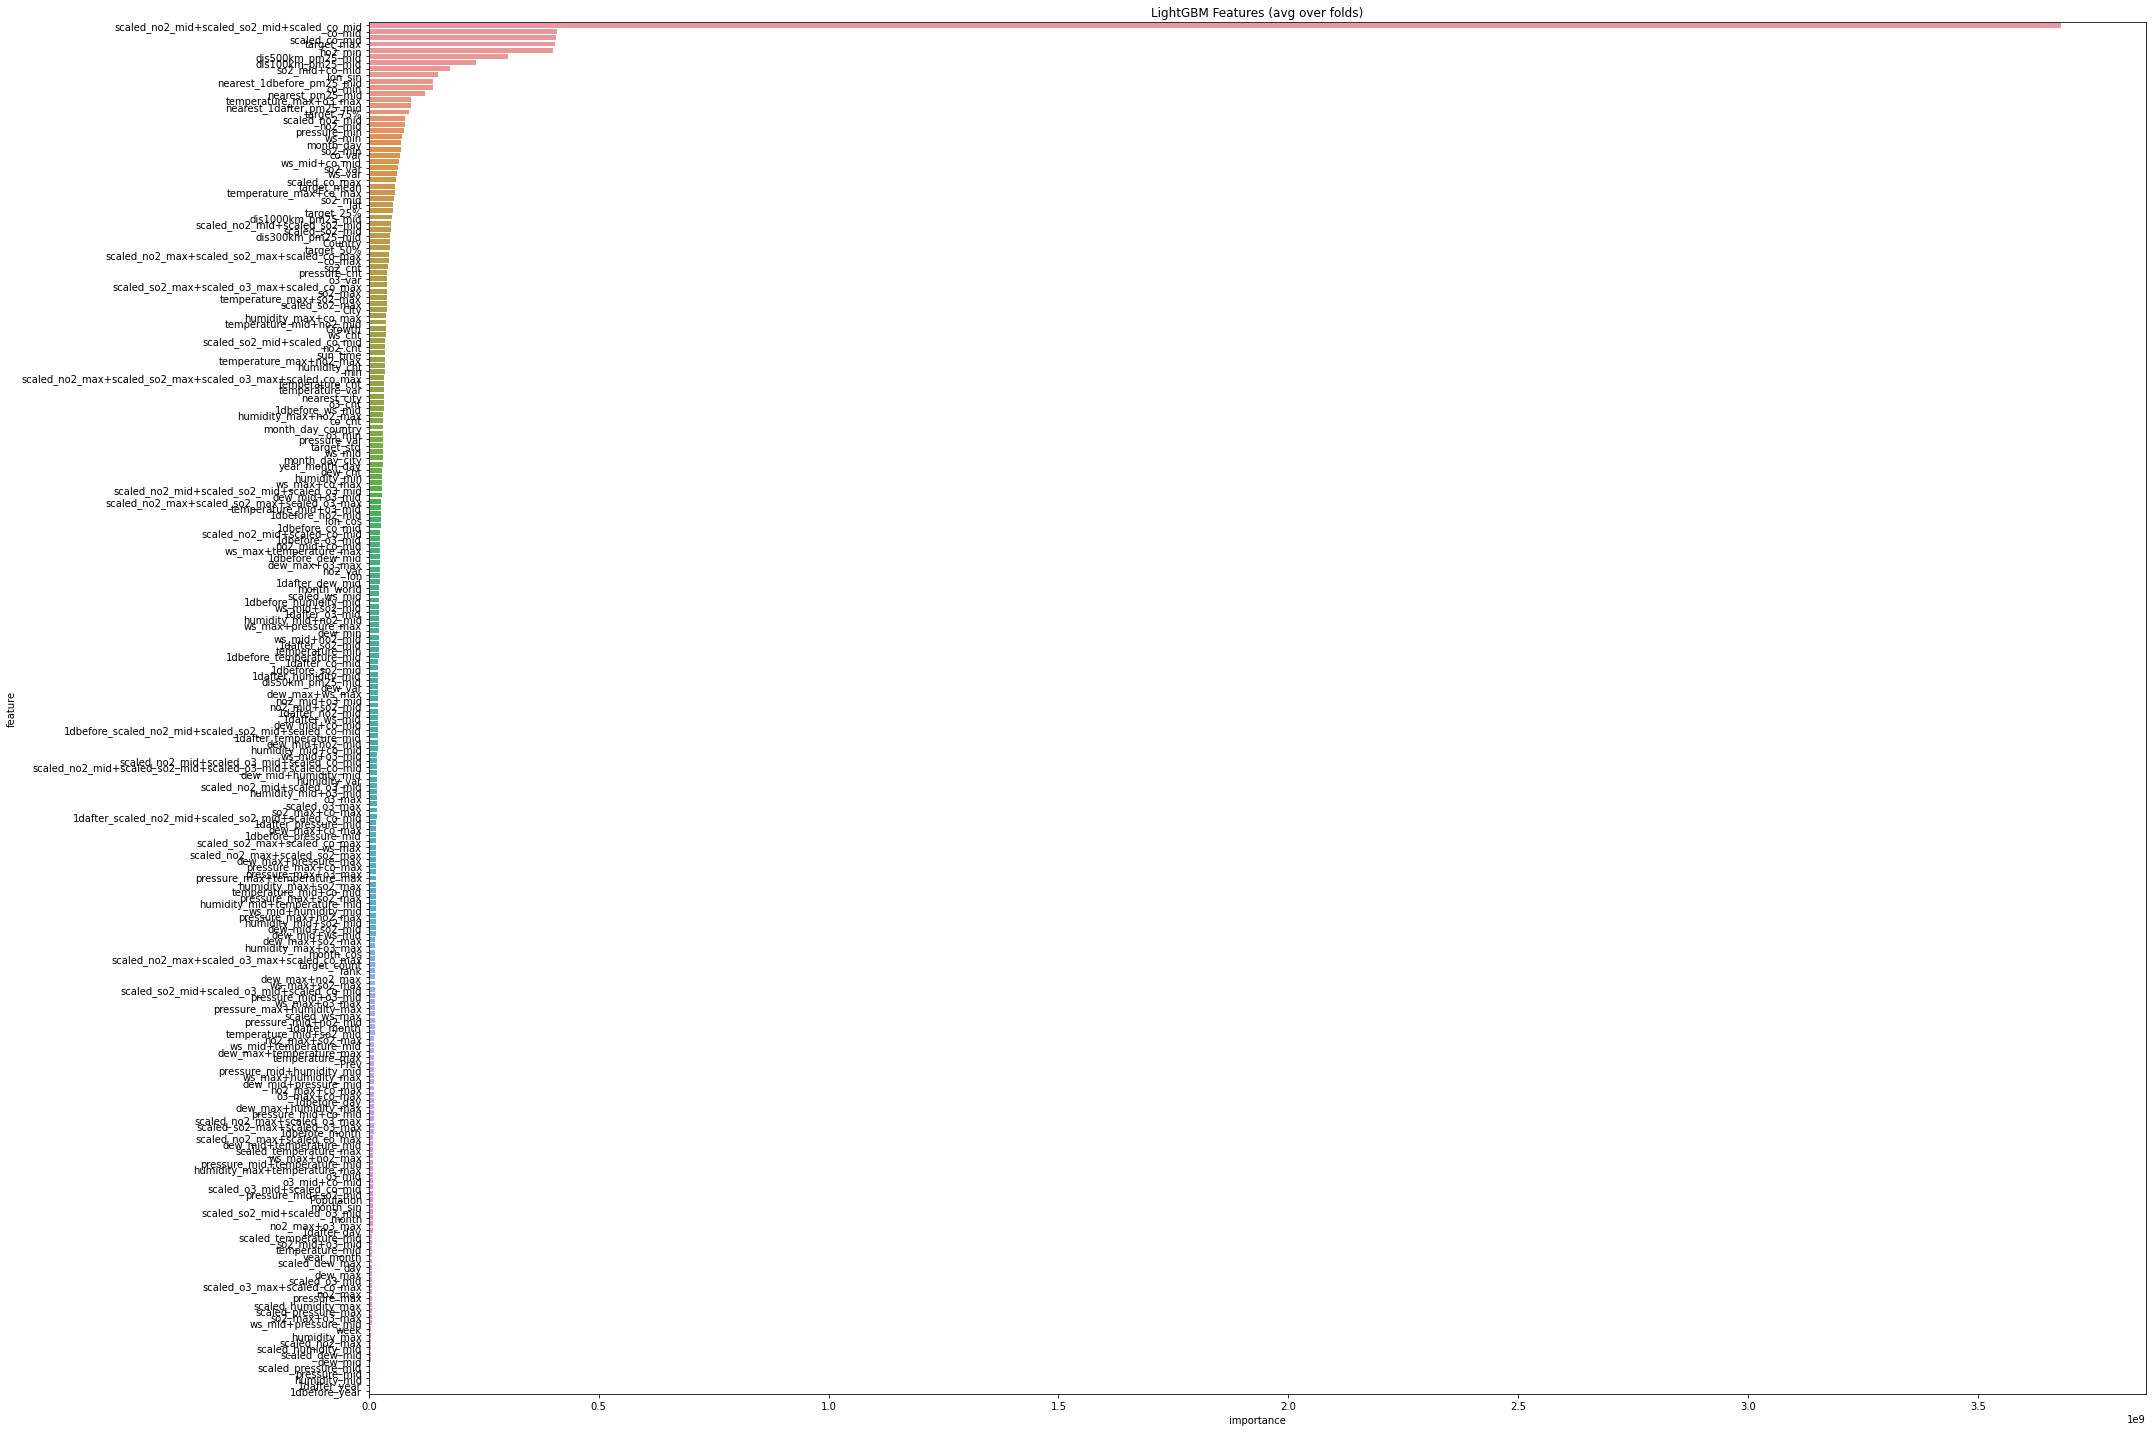

In [60]:
viz_feature_importances(feature_importance)

In [61]:
a = np.clip(train_oof["oof"], 0, 450)
oof_score = np.sqrt(mean_squared_error(train_oof["pm25_mid"], a))
oof_score = format(oof_score, ".4f")
print(f"oof score: {oof_score}")

### d_cs_flg 21.89 ###

# 24.11
# 20.85

oof score: 21.7610


In [62]:
train_oof[["id","pm25_mid", "kfold", "oof"]].to_csv(os.path.join(OOF_DIR, "oof.csv"), index= False)

In [63]:
test_df_

,id,year,month,day,Country,City,lat,lon,co_cnt,co_min,...,pm25_mid_x,pm25_mid_y,nearest_pm25_mid,nearest_1dbefore_pm25_mid,nearest_1dafter_pm25_mid,dis50km_pm25_mid,dis100km_pm25_mid,dis300km_pm25_mid,dis500km_pm25_mid,dis1000km_pm25_mid
0,195942,2019,1,1,Australia,Adelaide,-34.92866,138.59863,155,0.091,...,25.918,43.757293,25.918000,NaN,23.219000,NaN,NaN,NaN,NaN,25.918000
1,195943,2019,1,1,Australia,Sydney,-33.86785,151.20732,23,1.037,...,110.224,54.181153,110.224000,NaN,96.194000,NaN,110.224000,110.224000,110.224000,110.224000
2,195944,2019,1,1,Belgium,Brussels,50.85045,4.34878,28,0.096,...,73.848,64.552842,73.848000,NaN,61.599000,73.848,73.848000,73.848000,73.848000,73.848000
3,195945,2019,1,1,Bosnia and Herzegovina,Sarajevo,43.84864,18.35644,122,0.479,...,NaN,137.160667,137.160667,NaN,137.160667,NaN,137.160667,137.160667,137.160667,137.160667
4,195946,2019,1,1,Brazil,São José dos Campos,-23.17944,-45.88694,158,6.198,...,67.872,59.879795,67.872000,NaN,71.784000,NaN,67.872000,67.872000,67.872000,67.872000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53504,249446,2021,12,31,Turkey,Adana,36.98615,35.32531,97,4.674,...,143.083,112.648742,143.083000,212.630000,NaN,NaN,NaN,143.083000,143.083000,143.083000
53505,249447,2021,12,31,Turkey,Bursa,40.19559,29.06013,123,17.621,...,67.132,69.052822,67.132000,73.737000,NaN,NaN,67.132000,67.132000,67.132000,67.132000
53506,249448,2021,12,31,Turkey,Trabzon,41.00500,39.72694,150,0.128,...,152.706,127.241122,152.706000,172.940000,NaN,NaN,NaN,152.706000,152.706000,152.706000
53507,249449,2021,12,31,United Kingdom,London,51.50853,-0.12574,21,0.057,...,NaN,41.818333,41.818333,41.818333,NaN,NaN,41.818333,41.818333,41.818333,41.818333


# predict

In [64]:
sum_predict = None
for model in models:
    predict = model.predict(
        test_df__[use_cols],
    )
    if sum_predict is None:
        sum_predict = predict
    else:
        sum_predict += predict

mean_predict = sum_predict / len(models)

In [65]:
print(len(mean_predict))
print(sample_df.shape)
print(test_df.shape)

53509
(53509, 2)
(53509, 83)


In [66]:
sample_df.loc[:,"predict"] = np.clip(mean_predict, 0, 450)

In [67]:
sample_df.head()

,id,predict
0,195942,26.990246
1,195943,38.817895
2,195944,29.396414
3,195945,64.705790
4,195946,138.736250


In [68]:
sample_df.to_csv(os.path.join(SUB_DIR, "submission.csv"), index= False, header = False)

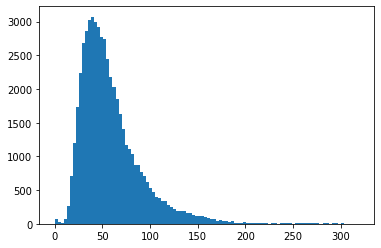

In [69]:
plt.hist(sample_df["predict"], bins = 100)
plt.show()

# submit

In [70]:
!pip install signate > /dev/null
!mkdir /root/.signate
!cp /content/drive/MyDrive/signate/signate.json /root/.signate/signate.json

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.9 which is incompatible.
google-colab 1.0.0 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [71]:
submission_file = os.path.join(SUB_DIR, "submission.csv")

In [72]:
comment = f"cv:{oof_score}_" + NOTEBOOK_NAME
comment

'cv:21.7610_FP035-034'

# Submit

In [73]:
!signate submit --competition-id=624 {submission_file} --note {comment}

You have successfully submitted your predictions.We will send you the submission result to your email address.


https://signate.jp/competitions/624/submissions

In [ ]:
train_df[["City", "month", "pm25_mid"]].groupby(["City"]).describe()

In [ ]:
train_df.columns

In [ ]:
train_df[["co_cnt", "co_var", "co_min", "co_max", "co_mid"]]

In [ ]:
gen = np.random.default_rng()

rnd = gen.normal(size=38)

print(len(rnd), rnd.mean(), rnd.std())

In [ ]:
plt.hist(train_df[train_df["City"] == "Adapazarı"]["pm25_mid"], bins = 100)